# Chapter 3 - Linear Regression

- [Load Datasets](#Load-Datasets)
- [3.1 Simple Linear Regression](#3.1-Simple-Linear-Regression)
- [3.2 Multiple Linear Regression](#3.2-Multiple-Linear-Regression)
- [3.3 Other Considerations in the Regression Model](#3.3-Other-Considerations-in-the-Regression-Model)

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
import requests
import csv

from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

### Load Datasets
Datasets available on http://www-bcf.usc.edu/~gareth/ISL/data.html

In [2]:
# read data function
def get_csv_df(url):
    with requests.Session() as s:
        download = s.get(url)
        decoded_content = download.content.decode('utf-8')
        cr = csv.reader(decoded_content.splitlines(), delimiter=',')
        return list(cr)

def standardize_names(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').\
      str.replace('(', '').str.replace(')', '')
    return df
    
    
advert_url = 'http://faculty.marshall.usc.edu/gareth-james/ISL/Advertising.csv'
advert_data = get_csv_df(advert_url)
advertising = pd.DataFrame(advert_data[1:], columns=advert_data[0])\
    [['TV', 'radio', 'newspaper', 'sales']]
advertising = advertising.apply(pd.to_numeric, errors='coerce')
advertising.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [3]:
credit_url = 'http://faculty.marshall.usc.edu/gareth-james/ISL/Credit.csv'
credit_data = get_csv_df(credit_url)
credit = standardize_names(pd.DataFrame(credit_data[1:], columns=credit_data[0]))
credit = credit.iloc[:, 1:]
credit['is_student'] = credit.student.map({'No':0, 'Yes':1})
credit['is_male'] = credit.gender.map({'Male':1, 'Female':0})
credit['is_married'] = credit.married.map({'No':0, 'Yes':1})
le = LabelEncoder()
credit['ethnicity'] = le.fit_transform(credit['ethnicity'])
credit.drop(columns=['gender', 'student', 'married'], inplace=True)
credit = credit.apply(pd.to_numeric, errors='coerce')
print(credit.info())
credit.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   income      400 non-null    float64
 1   limit       400 non-null    int64  
 2   rating      400 non-null    int64  
 3   cards       400 non-null    int64  
 4   age         400 non-null    int64  
 5   education   400 non-null    int64  
 6   ethnicity   400 non-null    int64  
 7   balance     400 non-null    int64  
 8   is_student  400 non-null    int64  
 9   is_male     400 non-null    int64  
 10  is_married  400 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 34.5 KB
None


,income,limit,rating,cards,age,education,ethnicity,balance,is_student,is_male,is_married
0,14.891,3606,283,2,34,11,2,333,0,1,1
1,106.025,6645,483,3,82,15,1,903,1,0,1
2,104.593,7075,514,4,71,11,1,580,0,1,0
3,148.924,9504,681,3,36,11,1,964,0,0,0
4,55.882,4897,357,2,68,16,2,331,0,1,1


In [4]:
auto_url = 'http://faculty.marshall.usc.edu/gareth-james/ISL/Auto.csv'
auto_data = get_csv_df(auto_url)
auto = pd.DataFrame(auto_data[1:], columns=auto_data[0])
auto.replace('?', np.nan, inplace=True)
auto.dropna(inplace=True)
auto[['mpg', 'cylinders', 'displacement', 
      'horsepower', 'weight', 'acceleration', 'year', 'origin']] = auto[['mpg', 'cylinders', 'displacement', 
      'horsepower', 'weight', 'acceleration', 'year', 'origin']].\
        apply(pd.to_numeric, errors='coerce')
print(auto.info())
auto.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    int64  
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(3), int64(5), object(1)
memory usage: 30.6+ KB
None


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


## 3.1 Simple Linear Regression

### Figure 3.1 - Least squares fit

In [5]:
advertising.TV

0      230.1
1       44.5
2       17.2
3      151.5
4      180.8
       ...  
195     38.2
196     94.2
197    177.0
198    283.6
199    232.1
Name: TV, Length: 200, dtype: float64

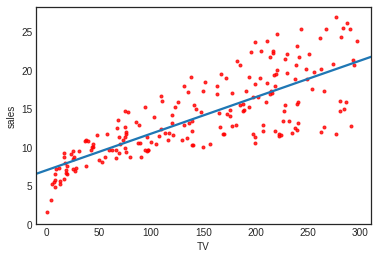

In [6]:
sns.regplot(advertising.TV, advertising.sales, 
            order=1, ci=None, scatter_kws={'color':'r', 's':9})
plt.xlim(-10,310)
plt.ylim(ymin=0);

### Figure 3.2 - Regression coefficients - RSS
Note that the text in the book describes the coefficients based on uncentered data, whereas the plot shows the model based on centered data. The latter is visually more appealing for explaining the concept of a minimum RSS. I think that, in order not to confuse the reader, the values on the axis of the B0 coefficients have been changed to correspond with the text. The axes on the plots below are unaltered.

In [7]:
# Regression coefficients (Ordinary Least Squares)
regr = skl_lm.r()

X = scale(advertising.TV, with_mean=True, with_std=False).reshape(-1,1)
y = advertising.sales

regr.fit(X,y)
print(regr.intercept_)
print(regr.coef_)

14.0225
[0.04753664]


In [8]:
# Create grid coordinates for plotting
B0 = np.linspace(regr.intercept_-2, regr.intercept_+2, 50)
B1 = np.linspace(regr.coef_-0.02, regr.coef_+0.02, 50)
xx, yy = np.meshgrid(B0, B1, indexing='xy')
Z = np.zeros((B0.size,B1.size))

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z):
    Z[i,j] =((y - (xx[i,j]+X.ravel()*yy[i,j]))**2).sum()/1000

# Minimized RSS
min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
min_rss = np.sum((regr.intercept_+regr.coef_*X - y.values.reshape(-1,1))**2)/1000
min_rss

2.1025305831313514

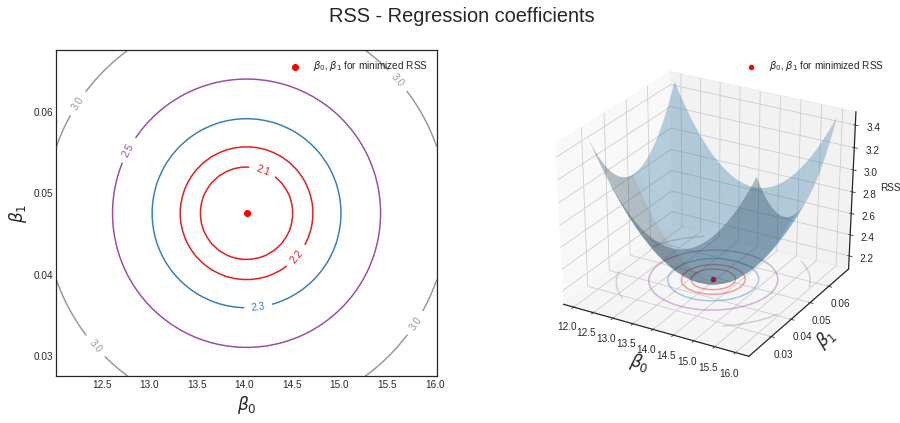

In [9]:
fig = plt.figure(figsize=(15,6))
fig.suptitle('RSS - Regression coefficients', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# Left plot
CS = ax1.contour(xx, yy, Z, cmap=plt.cm.Set1, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax1.scatter(regr.intercept_, regr.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')

# Right plot
ax2.plot_surface(xx, yy, Z, rstride=3, cstride=3, alpha=0.3)
ax2.contour(xx, yy, Z, zdir='z', offset=Z.min(), cmap=plt.cm.Set1,
            alpha=0.4, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax2.scatter3D(regr.intercept_, regr.coef_[0], min_rss, c='r', label=min_RSS)
ax2.set_zlabel('RSS')
ax2.set_zlim(Z.min(),Z.max())
ax2.set_ylim(0.02,0.07)

# settings common to both plots
for ax in fig.axes:
    ax.set_xlabel(r'$\beta_0$', fontsize=17)
    ax.set_ylabel(r'$\beta_1$', fontsize=17)
    ax.set_yticks([0.03,0.04,0.05,0.06])
    ax.legend()

### Confidence interval on page 67 & Table 3.1 & 3.2 - Statsmodels 

In [10]:
est = smf.ols('sales ~ TV', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.0326,0.458,15.360,0.000,6.130,7.935
TV,0.0475,0.003,17.668,0.000,0.042,0.053


In [11]:
# RSS with regression coefficients
((advertising.sales - (est.params[0] + est.params[1]*advertising.TV))**2).sum()/1000

2.102530583131351

### Table 3.1 & 3.2 - Scikit-learn

In [12]:
regr = skl_lm.LinearRegression()

X = advertising.TV.values.reshape(-1,1)
y = advertising.sales

regr.fit(X,y)
print(regr.intercept_)
print(regr.coef_)

7.032593549127695
[0.04753664]


In [13]:
Sales_pred = regr.predict(X)
r2_score(y, Sales_pred)

0.611875050850071

## 3.2 Multiple Linear Regression

### Table 3.3 - Statsmodels

In [14]:
est = smf.ols('sales ~ radio', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9.3116,0.563,16.542,0.000,8.202,10.422
radio,0.2025,0.020,9.921,0.000,0.162,0.243


In [15]:
est = smf.ols('sales ~ newspaper', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,12.3514,0.621,19.876,0.000,11.126,13.577
newspaper,0.0547,0.017,3.300,0.001,0.022,0.087


### Table 3.4 & 3.6 - Statsmodels

In [16]:
est = smf.ols('sales ~ TV + radio + newspaper', advertising).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Tue, 12 May 2020   Prob (F-statistic):           1.58e-96
Time:                        14:43:42   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
radio          0.1885      0.009     21.893      0.000       0.172       0.206
newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Table 3.5 - Correlation Matrix

In [17]:
advertising.corr()

,TV,radio,newspaper,sales
TV,1.000000,0.054809,0.056648,0.782224
radio,0.054809,1.000000,0.354104,0.576223
newspaper,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


### Figure 3.5 - Multiple Linear Regression

In [18]:
regr = skl_lm.LinearRegression()

X = advertising[['radio', 'TV']].to_numpy()
y = advertising.sales

regr.fit(X,y)
print(regr.coef_)
print(regr.intercept_)

[0.18799423 0.04575482]
2.9210999124051398


In [19]:
# What are the min/max values of Radio & TV?
# Use these values to set up the grid for plotting.
advertising[['radio', 'TV']].describe()

,radio,TV
count,200.000000,200.000000
mean,23.264000,147.042500
std,14.846809,85.854236
min,0.000000,0.700000
25%,9.975000,74.375000
50%,22.900000,149.750000
75%,36.525000,218.825000
max,49.600000,296.400000


In [20]:
# Create a coordinate grid
Radio = np.arange(0,50)
TV = np.arange(0,300)

B1, B2 = np.meshgrid(Radio, TV, indexing='xy')
Z = np.zeros((TV.size, Radio.size))

for (i,j),v in np.ndenumerate(Z):
        Z[i,j] =(regr.intercept_ + B1[i,j]*regr.coef_[0] + B2[i,j]*regr.coef_[1])

/home/troysattgast/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  del sys.path[0]


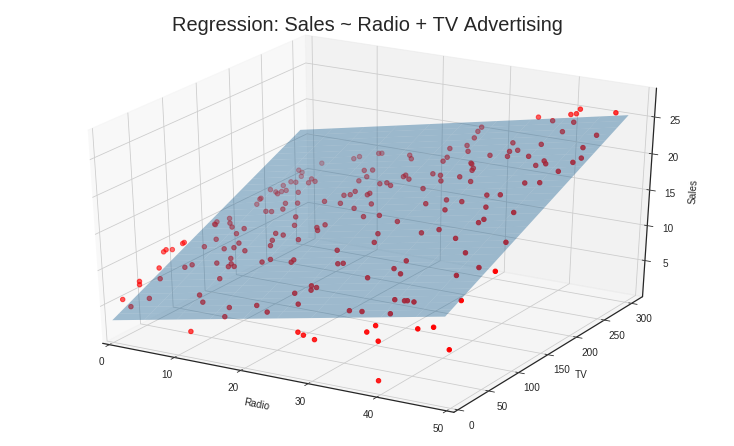

In [21]:
# Create plot
fig = plt.figure(figsize=(10,6))
fig.suptitle('Regression: Sales ~ Radio + TV Advertising', fontsize=20)

ax = axes3d.Axes3D(fig)

ax.plot_surface(B1, B2, Z, rstride=10, cstride=5, alpha=0.4)
ax.scatter3D(advertising.radio, advertising.TV, advertising.sales, c='r')

ax.set_xlabel('Radio')
ax.set_xlim(0,50)
ax.set_ylabel('TV')
ax.set_ylim(ymin=0)
ax.set_zlabel('Sales');

## 3.3 Other Considerations in the Regression Model

### Figure 3.6

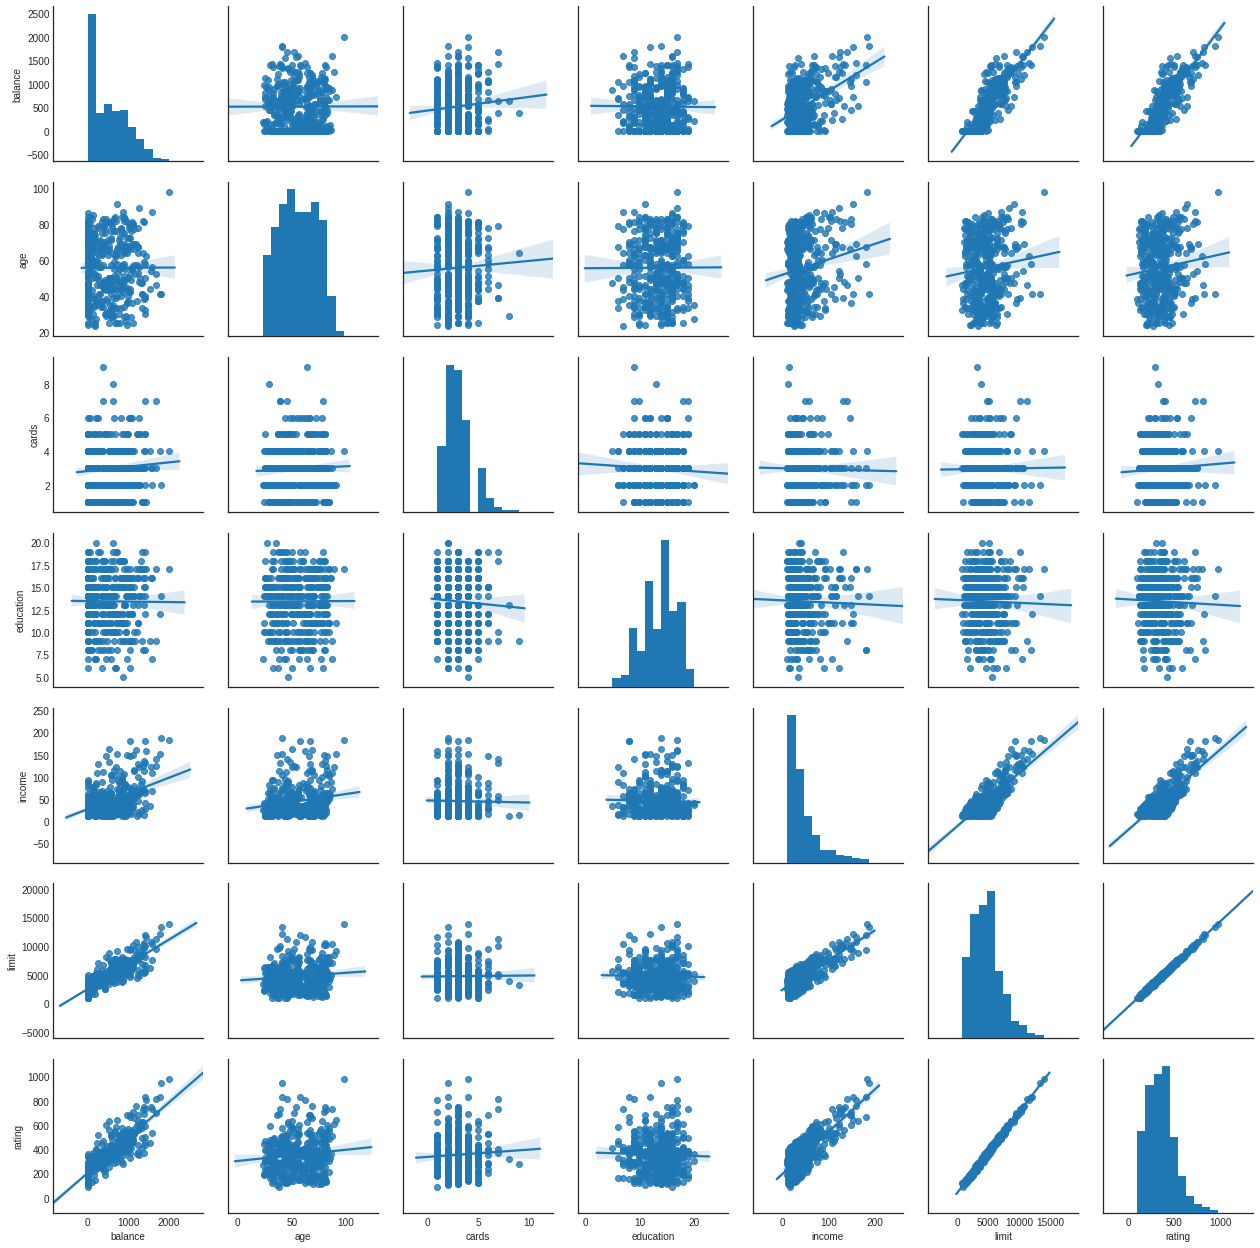

In [22]:
sns.pairplot(credit[['balance','age','cards','education','income','limit','rating']],
            kind='reg')


In [23]:
credit.head()

,income,limit,rating,cards,age,education,ethnicity,balance,is_student,is_male,is_married
0,14.891,3606,283,2,34,11,2,333,0,1,1
1,106.025,6645,483,3,82,15,1,903,1,0,1
2,104.593,7075,514,4,71,11,1,580,0,1,0
3,148.924,9504,681,3,36,11,1,964,0,0,0
4,55.882,4897,357,2,68,16,2,331,0,1,1


###  Table 3.7

In [24]:
est = smf.ols('balance ~ is_male', credit).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,529.5362,31.988,16.554,0.000,466.649,592.423
is_male,-19.7331,46.051,-0.429,0.669,-110.267,70.801


### Table 3.8

In [25]:
est = smf.ols('balance ~ ethnicity', credit).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,526.3772,41.743,12.610,0.000,444.313,608.442
ethnicity,-5.0897,27.860,-0.183,0.855,-59.860,49.681


### Table 3.9 - Interaction Variables

In [26]:
est = smf.ols('sales ~ TV + radio + TV*radio', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.7502,0.248,27.233,0.000,6.261,7.239
TV,0.0191,0.002,12.699,0.000,0.016,0.022
radio,0.0289,0.009,3.241,0.001,0.011,0.046
TV:radio,0.0011,5.24e-05,20.727,0.000,0.001,0.001


### Figure 3.7 - Interaction between qualitative and quantative variables

In [27]:
est1 = smf.ols('balance ~ income + is_student', credit).fit()
regr1 = est1.params
est2 = smf.ols('balance ~ income + income*is_student', credit).fit()
regr2 = est2.params

print('Regression 1 - without interaction term')
print(regr1)
print('\nRegression 2 - with interaction term')
print(regr2)

Regression 1 - without interaction term
Intercept     211.142964
income          5.984336
is_student    382.670539
dtype: float64

Regression 2 - with interaction term
Intercept            200.623153
income                 6.218169
is_student           476.675843
income:is_student     -1.999151
dtype: float64


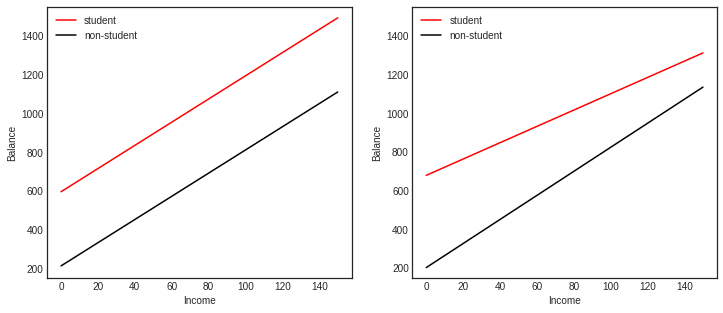

In [28]:
# Income (x-axis)
income = np.linspace(0,150)

# Balance without interaction term (y-axis)
student1 = np.linspace(regr1['Intercept']+regr1['is_student'],
                       regr1['Intercept']+regr1['is_student']+150*regr1['income'])
non_student1 =  np.linspace(regr1['Intercept'], regr1['Intercept']+150*regr1['income'])

# Balance with iteraction term (y-axis)
student2 = np.linspace(regr2['Intercept']+regr2['is_student'],
                       regr2['Intercept']+regr2['is_student']+
                       150*(regr2['income']+regr2['income:is_student']))
non_student2 =  np.linspace(regr2['Intercept'], regr2['Intercept']+150*regr2['income'])

# Create plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(income, student1, 'r', income, non_student1, 'k')
ax2.plot(income, student2, 'r', income, non_student2, 'k')

for ax in fig.axes:
    ax.legend(['student', 'non-student'], loc=2)
    ax.set_xlabel('Income')
    ax.set_ylabel('Balance')
    ax.set_ylim(ymax=1550)

### Figure 3.8 - Non-linear relationships

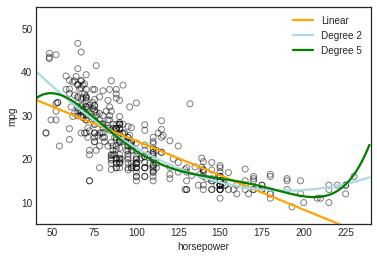

In [29]:
# With Seaborn's regplot() you can easily plot higher order polynomials.
plt.scatter(auto.horsepower, auto.mpg, facecolors='None', edgecolors='k', alpha=.5) 
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Linear', scatter=False, color='orange')
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Degree 2', order=2, scatter=False, color='lightblue')
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Degree 5', order=5, scatter=False, color='g')
plt.legend()
plt.ylim(5,55)
plt.xlim(40,240);

### Table 3.10

In [30]:
auto['horsepower2'] = auto.horsepower**2
auto.head(3)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,horsepower2
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,16900
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,27225
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,22500


In [31]:
est = smf.ols('mpg ~ horsepower + horsepower2', auto).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,56.9001,1.800,31.604,0.000,53.360,60.440
horsepower,-0.4662,0.031,-14.978,0.000,-0.527,-0.405
horsepower2,0.0012,0.000,10.080,0.000,0.001,0.001


### Figure 3.9

In [32]:
regr = skl_lm.LinearRegression()

# Linear fit
X = auto.horsepower.values.reshape(-1,1)
y = auto.mpg
regr.fit(X, y)

auto['pred1'] = regr.predict(X)
auto['resid1'] = auto.mpg - auto.pred1

# Quadratic fit
X2 = auto[['horsepower', 'horsepower2']].to_numpy()
regr.fit(X2, y)

auto['pred2'] = regr.predict(X2)
auto['resid2'] = auto.mpg - auto.pred2

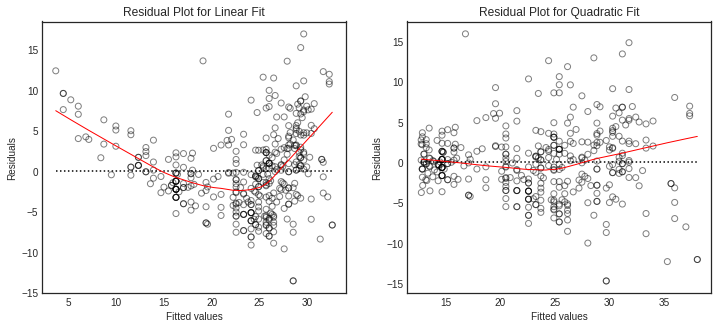

In [33]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
sns.regplot(auto.pred1, auto.resid1, lowess=True, 
            ax=ax1, line_kws={'color':'r', 'lw':1},
            scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.5})
ax1.hlines(0,xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dotted')
ax1.set_title('Residual Plot for Linear Fit')

# Right plot
sns.regplot(auto.pred2, auto.resid2, lowess=True,
            line_kws={'color':'r', 'lw':1}, ax=ax2,
            scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.5})
ax2.hlines(0,xmin=ax2.xaxis.get_data_interval()[0],
           xmax=ax2.xaxis.get_data_interval()[1], linestyles='dotted')
ax2.set_title('Residual Plot for Quadratic Fit')

for ax in fig.axes:
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')

### Figure 3.14

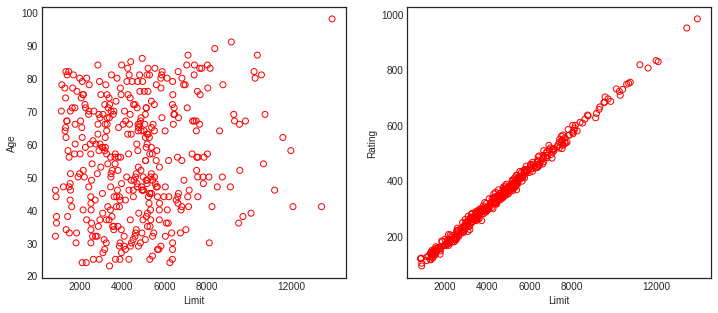

In [34]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
ax1.scatter(credit.limit, credit.age, facecolor='None', edgecolor='r')
ax1.set_ylabel('Age')

# Right plot
ax2.scatter(credit.limit, credit.rating, facecolor='None', edgecolor='r')
ax2.set_ylabel('Rating')

for ax in fig.axes:
    ax.set_xlabel('Limit')
    ax.set_xticks([2000,4000,6000,8000,12000])

### Figure 3.15

In [35]:
y = credit.balance

# Regression for left plot
X = credit[['age', 'limit']].to_numpy()
regr1 = skl_lm.LinearRegression()
regr1.fit(scale(X.astype('float'), with_std=False), y)
print('Age/Limit\n',regr1.intercept_)
print(regr1.coef_)

# Regression for right plot
X2 = credit[['rating', 'limit']].to_numpy()
regr2 = skl_lm.LinearRegression()
regr2.fit(scale(X2.astype('float'), with_std=False), y)
print('\nRating/Limit\n',regr2.intercept_)
print(regr2.coef_)

Age/Limit
 520.0150000000001
[-2.29148553  0.17336497]

Rating/Limit
 520.015
[2.20167217 0.02451438]


In [36]:
# Create grid coordinates for plotting
B_Age = np.linspace(regr1.coef_[0]-3, regr1.coef_[0]+3, 100)
B_Limit = np.linspace(regr1.coef_[1]-0.02, regr1.coef_[1]+0.02, 100)

B_Rating = np.linspace(regr2.coef_[0]-3, regr2.coef_[0]+3, 100)
B_Limit2 = np.linspace(regr2.coef_[1]-0.2, regr2.coef_[1]+0.2, 100)

X1, Y1 = np.meshgrid(B_Limit, B_Age, indexing='xy')
X2, Y2 = np.meshgrid(B_Limit2, B_Rating, indexing='xy')
Z1 = np.zeros((B_Age.size,B_Limit.size))
Z2 = np.zeros((B_Rating.size,B_Limit2.size))

Limit_scaled = scale(credit.limit.astype('float'), with_std=False)
Age_scaled = scale(credit.age.astype('float'), with_std=False)
Rating_scaled = scale(credit.rating.astype('float'), with_std=False)

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z1):
    Z1[i,j] =((y - (regr1.intercept_ + X1[i,j]*Limit_scaled +
                    Y1[i,j]*Age_scaled))**2).sum()/1000000
    
for (i,j),v in np.ndenumerate(Z2):
    Z2[i,j] =((y - (regr2.intercept_ + X2[i,j]*Limit_scaled +
                    Y2[i,j]*Rating_scaled))**2).sum()/1000000

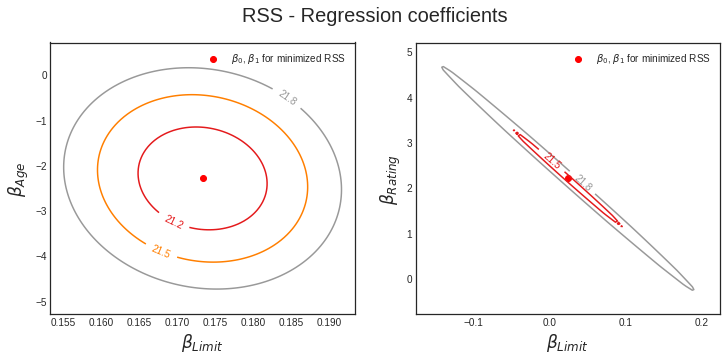

In [37]:
fig = plt.figure(figsize=(12,5))
fig.suptitle('RSS - Regression coefficients', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
    
# Left plot
CS = ax1.contour(X1, Y1, Z1, cmap=plt.cm.Set1, levels=[21.25, 21.5, 21.8])
ax1.scatter(regr1.coef_[1], regr1.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')
ax1.set_ylabel(r'$\beta_{Age}$', fontsize=17)

# Right plot
CS = ax2.contour(X2, Y2, Z2, cmap=plt.cm.Set1, levels=[21.5, 21.8])
ax2.scatter(regr2.coef_[1], regr2.coef_[0], c='r', label=min_RSS)
ax2.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')
ax2.set_ylabel(r'$\beta_{Rating}$', fontsize=17)
ax2.set_xticks([-0.1, 0, 0.1, 0.2])

for ax in fig.axes:
    ax.set_xlabel(r'$\beta_{Limit}$', fontsize=17)
    ax.legend()

### Variance Inflation Factor - page 102

In [38]:
est_Age = smf.ols('age ~ rating + limit', credit).fit()
est_Rating = smf.ols('rating ~ age + limit', credit).fit()
est_Limit = smf.ols('limit ~ age + rating', credit).fit()

print(1/(1-est_Age.rsquared))
print(1/(1-est_Rating.rsquared))
print(1/(1-est_Limit.rsquared))

1.0113846860681328
160.66830095856935
160.59287978597942
